# 1. 베이지안 추론의 철학
## 사후확률의 베이지안 업데이트

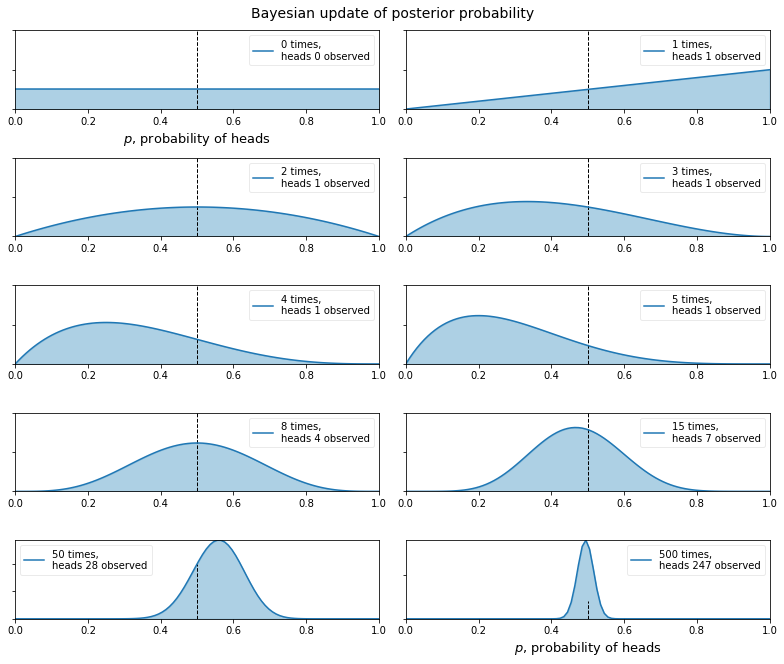

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.font_manager as fm

figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0,1,2,3,4,5,8,15,50,500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0,1,100)

for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)/2, 2, k+1)
    plt.xlabel("$p$, probability of heads", fontsize=13) if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1+heads, 1+N-heads)
    plt.plot(x, y, label="%d times,\nheads %d observed" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)
    
plt.suptitle("Bayesian update of posterior probability", y=1.02, fontsize=14)
plt.tight_layout()

## 예제: 사서일까, 농부일까?

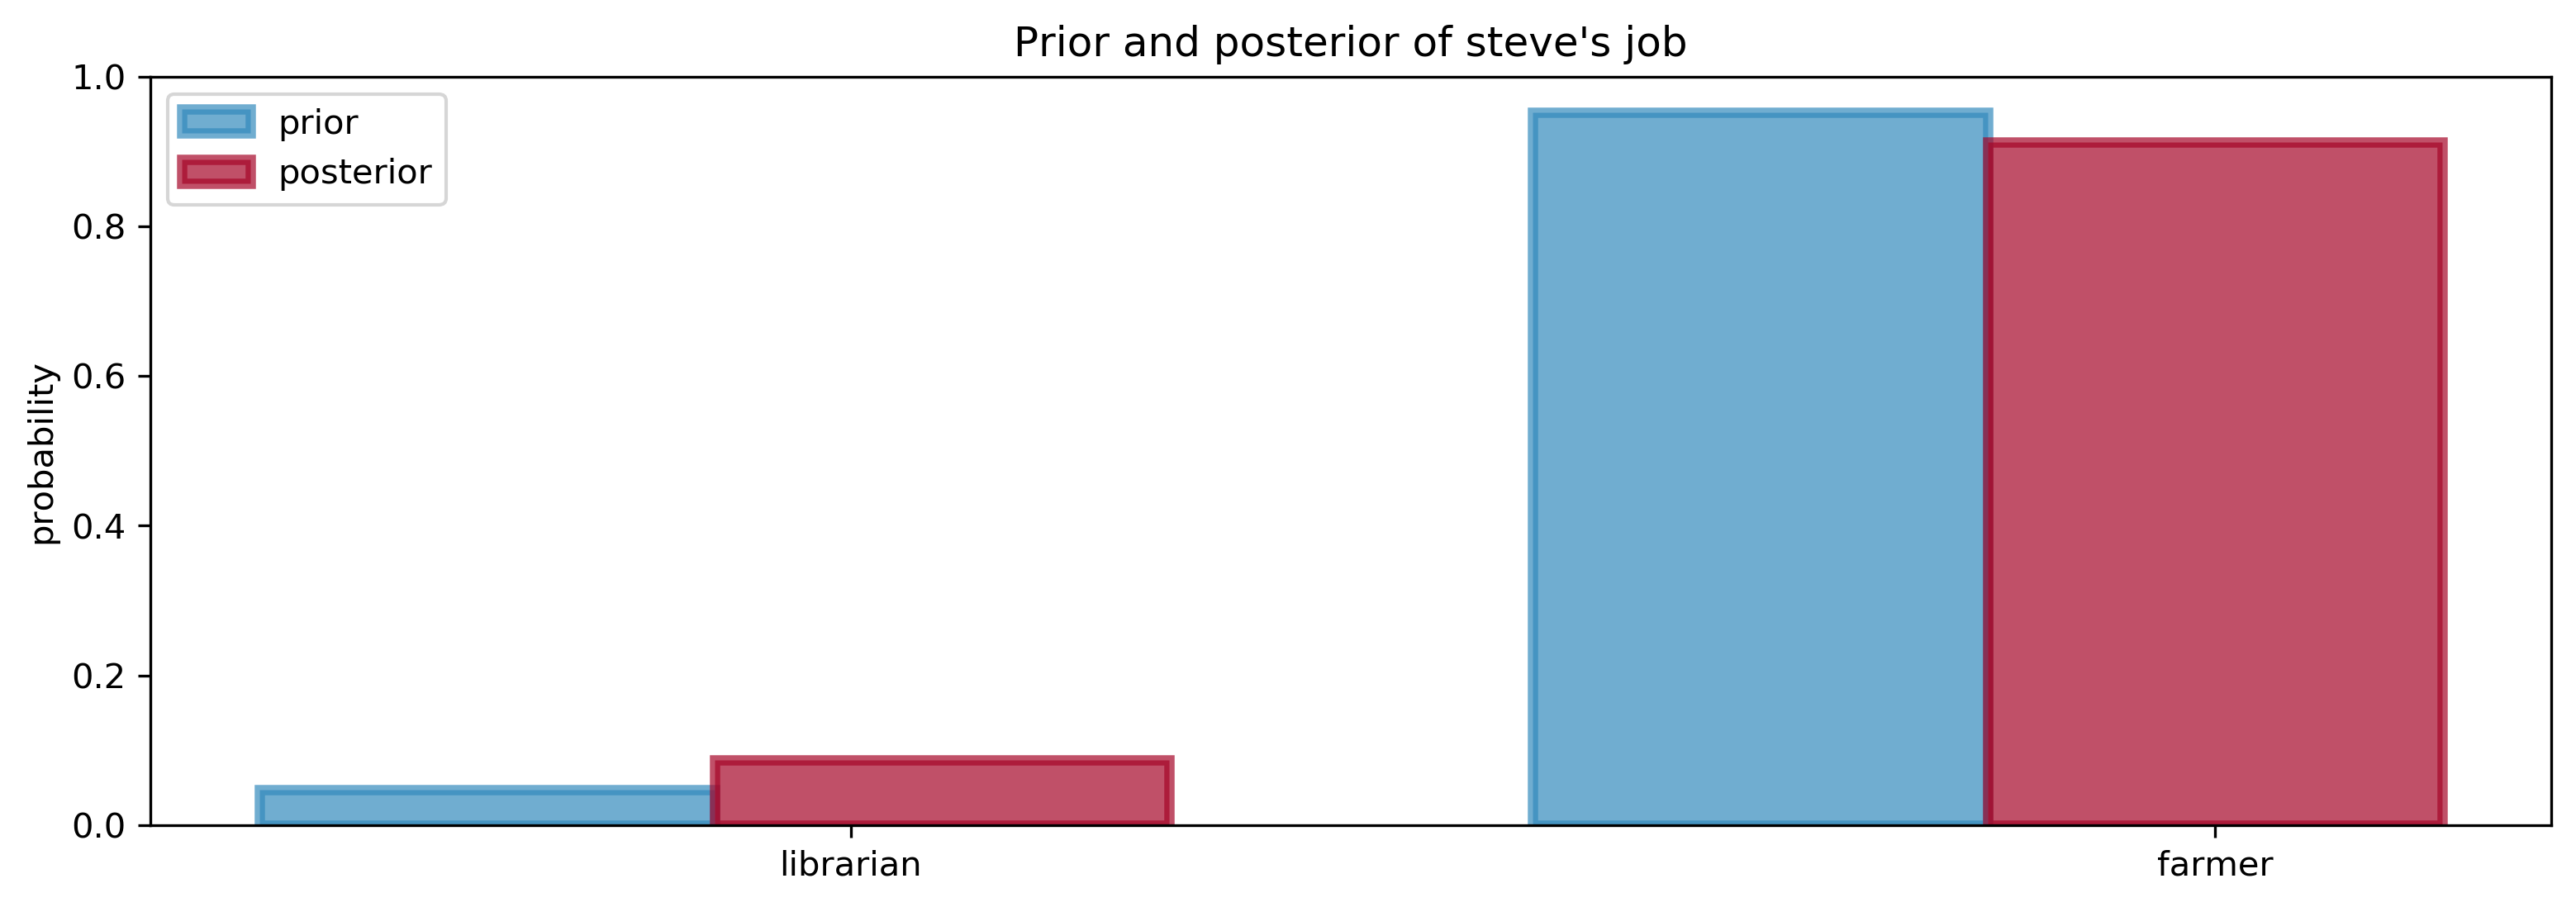

In [2]:
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

colors = ["#348ABD", "#A60628"]
prior = [1/21., 20/21.]
posterior = [0.087, 1-0.087]
plt.bar([0, .7], prior, alpha=0.70, width=0.25,
       color=colors[0], label="prior",
       lw="3", edgecolor=colors[0])

plt.bar([0+0.25, .7+0.25], posterior, alpha=0.7,
       width=0.25, color=colors[1],
       label="posterior",
       lw="3", edgecolor=colors[1])

plt.xticks([0.2, 0.95], ["librarian", "farmer"])
plt.title("Prior and posterior of steve's job")
plt.ylabel("probability")
plt.legend(loc="upper left")

## 확률 분포

Text(0.5, 1.0, 'Probability mass function of poisson random variable with different $\\lambda$')

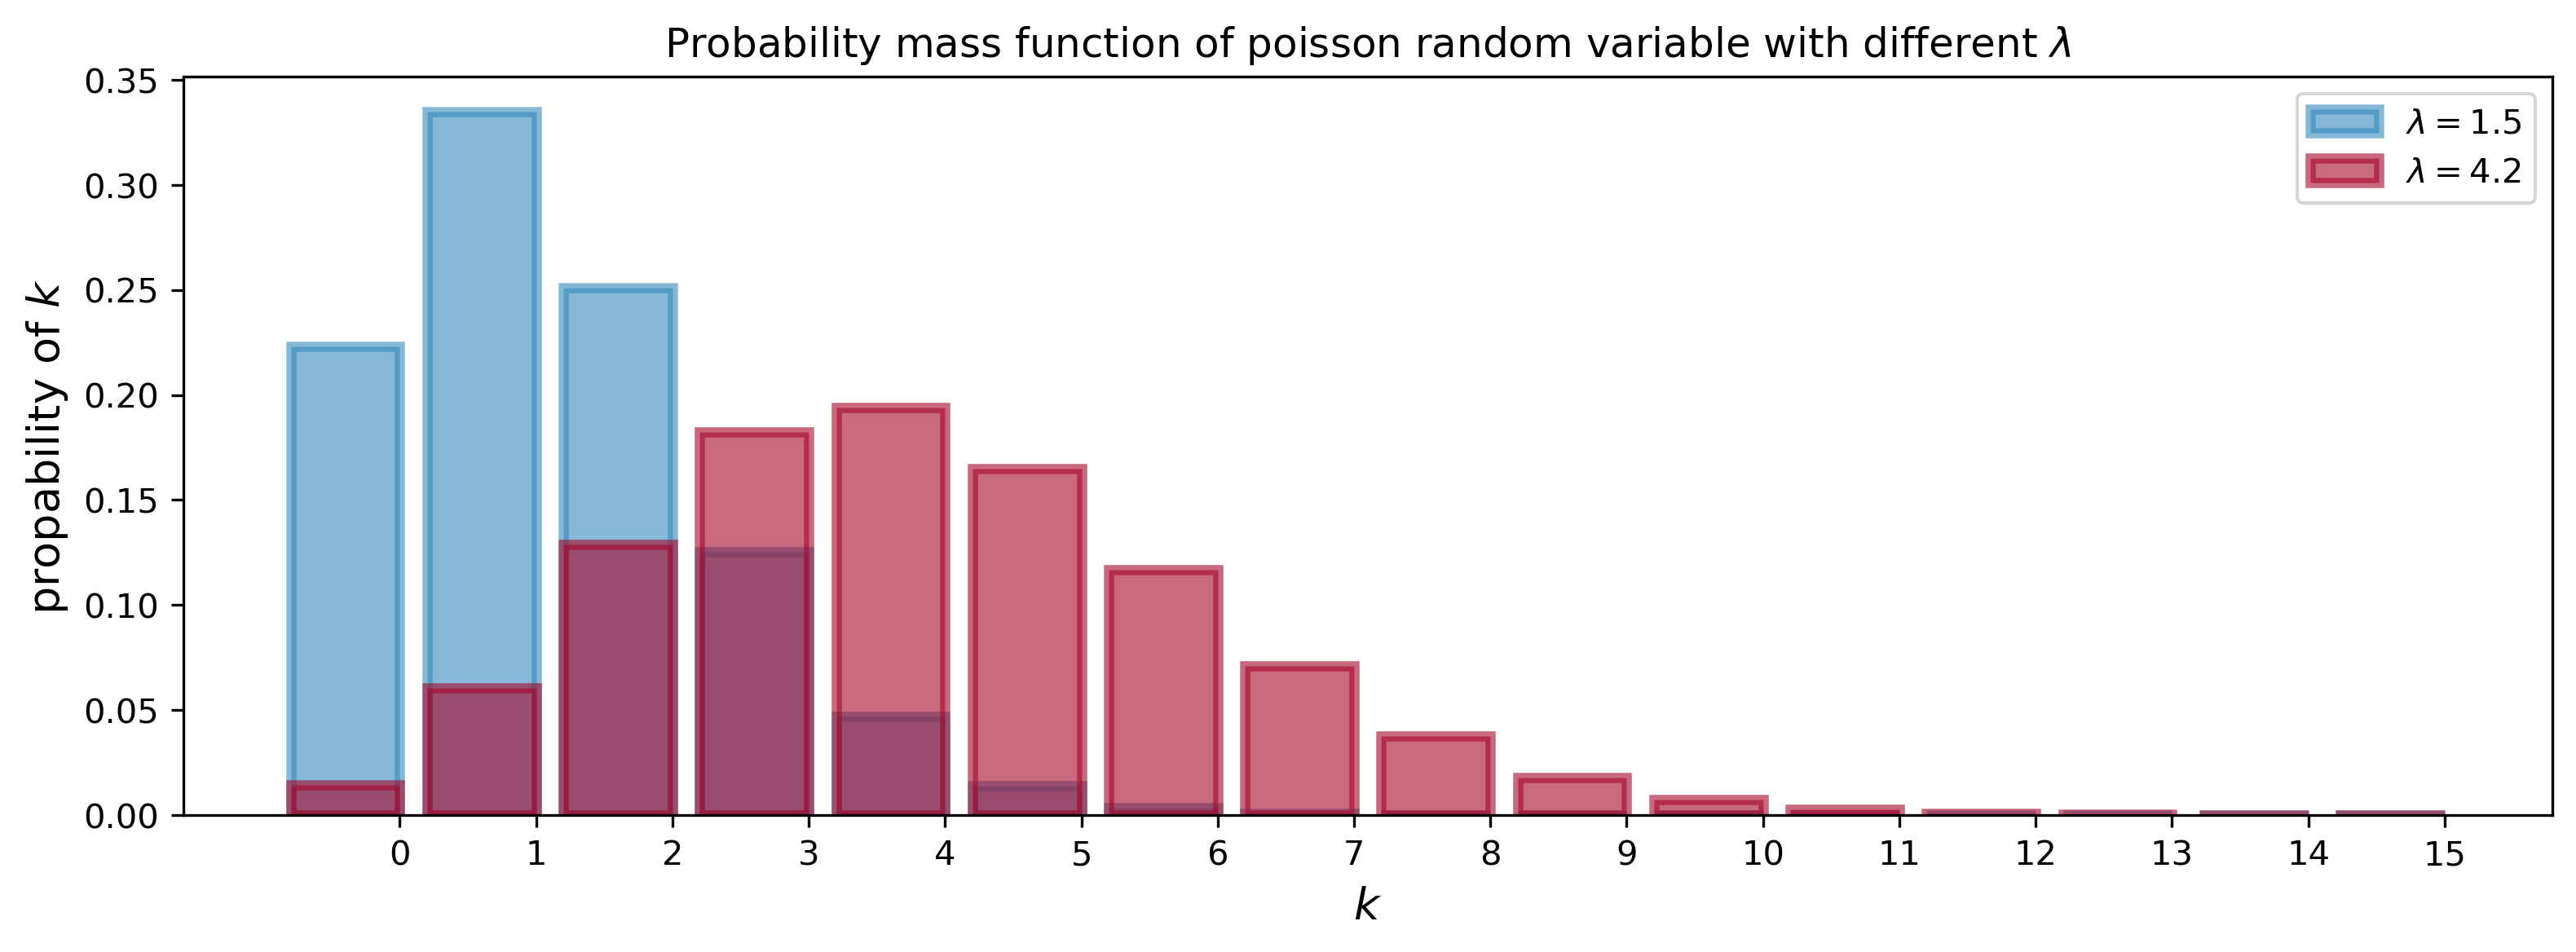

In [3]:
figsize(12.5, 4)

a = np.arange(16)
poi = stats.poisson
lambda_= [1.5, 4.25]
colors = ["#348ABD", "#A60628"]
plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0], label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
       edgecolor=colors[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1], label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
       edgecolor=colors[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("propability of $k$", fontsize=13)
plt.xlabel("$k$", fontsize=13)
plt.title("Probability mass function of poisson random variable with different $\lambda$")

Text(0.5, 1.0, 'PDF of exponential random variable with several $\\lambda$ values')

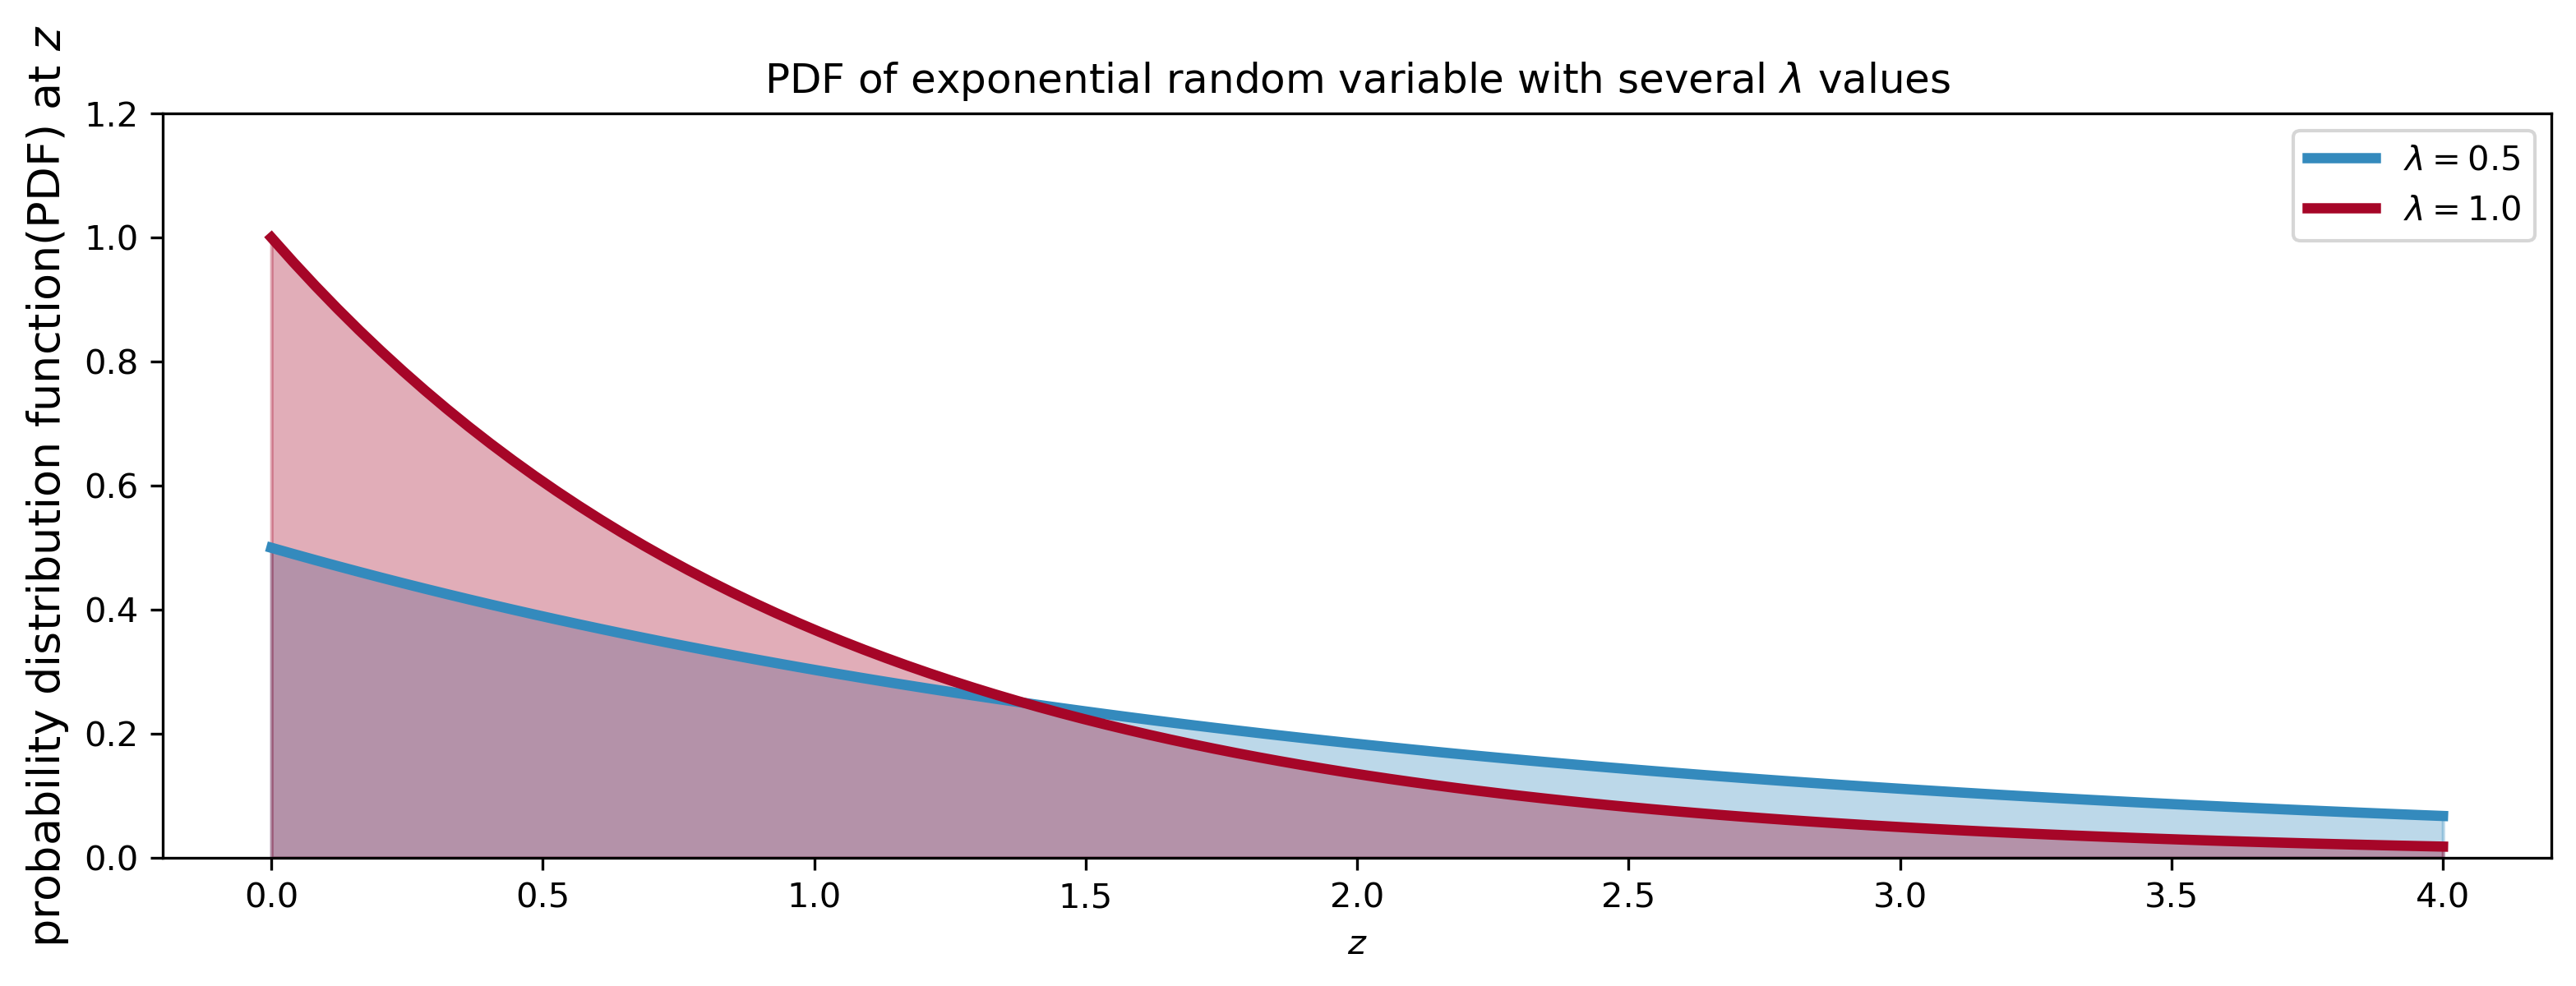

In [4]:
a = np.linspace(0,4,100)
expo = stats.expon
lambda_ = [0.5,1]

for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3, color=c, label="$\lambda=%.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)
    
plt.legend()
plt.ylabel("probability distribution function(PDF) at $z$", fontsize=13)
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.title("PDF of exponential random variable with several $\lambda$ values")

## 예제: 문자 메시지 데이터에서 행동 추론하기

(0, 74)

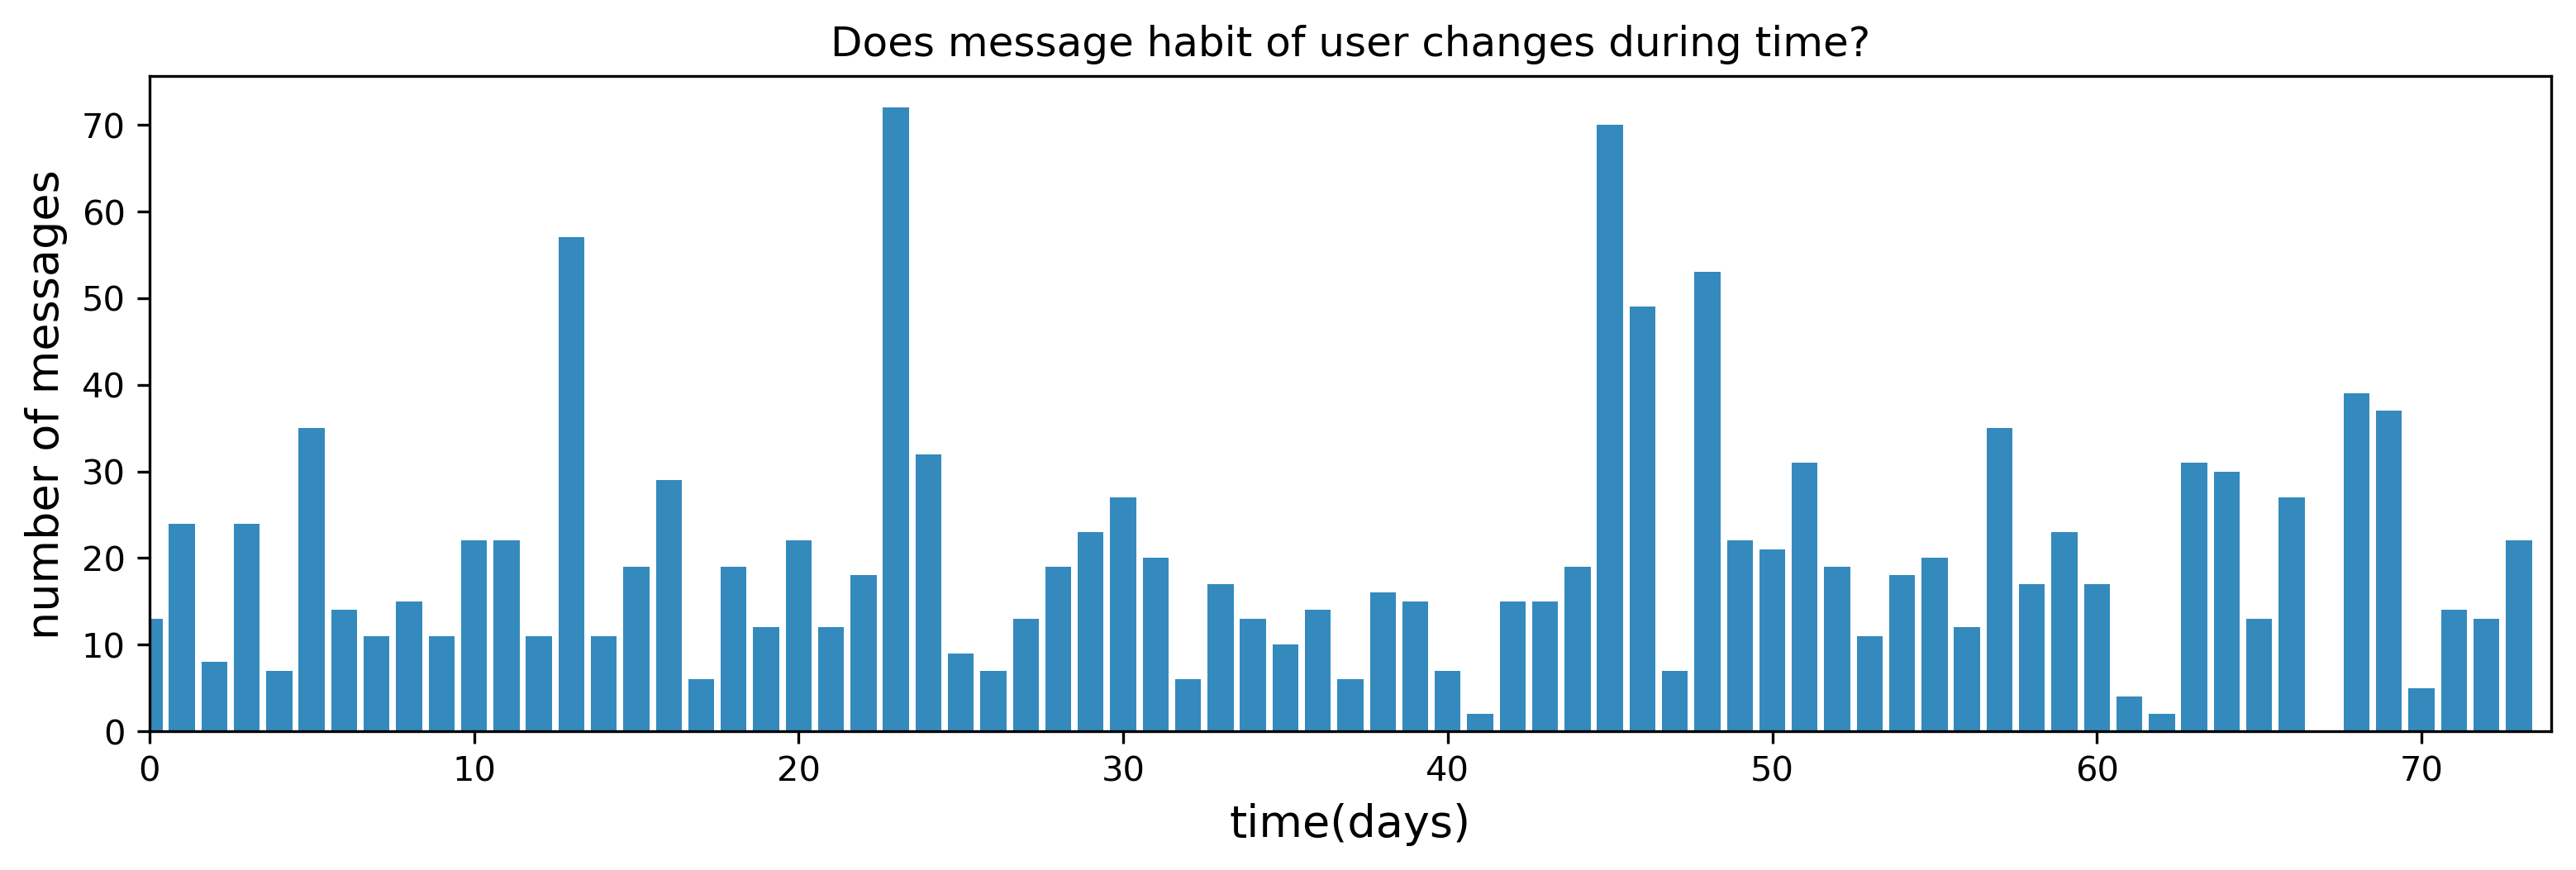

In [5]:
figsize(12.5, 3.5)
count_data = np.loadtxt(r"data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("time(days)", fontsize=13)
plt.ylabel("number of messages", fontsize=13)
plt.title("Does message habit of user changes during time?")
plt.xlim(0, n_count_data)

## PyMC

In [6]:
import pymc as pm

alpha = 1.0/count_data.mean()
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data) # 확률론적 변수(stochastic variable)

In [7]:
print("Random output:", tau.random(), tau.random(), tau.random())

Random output: 54 32 56


In [8]:
@pm.deterministic # 결정함수임을 알려주는 데코레이터
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1 # lambda_1은 tau 이전 lambda다.
    out[tau:] = lambda_2 # lambda_2은 tau 이후 lambda다.
    return out

In [9]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

In [10]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

/home/cjhan/anaconda3/envs/bayesian/lib/python3.8/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 5.5 sec

Text(0, 0.5, 'probability')

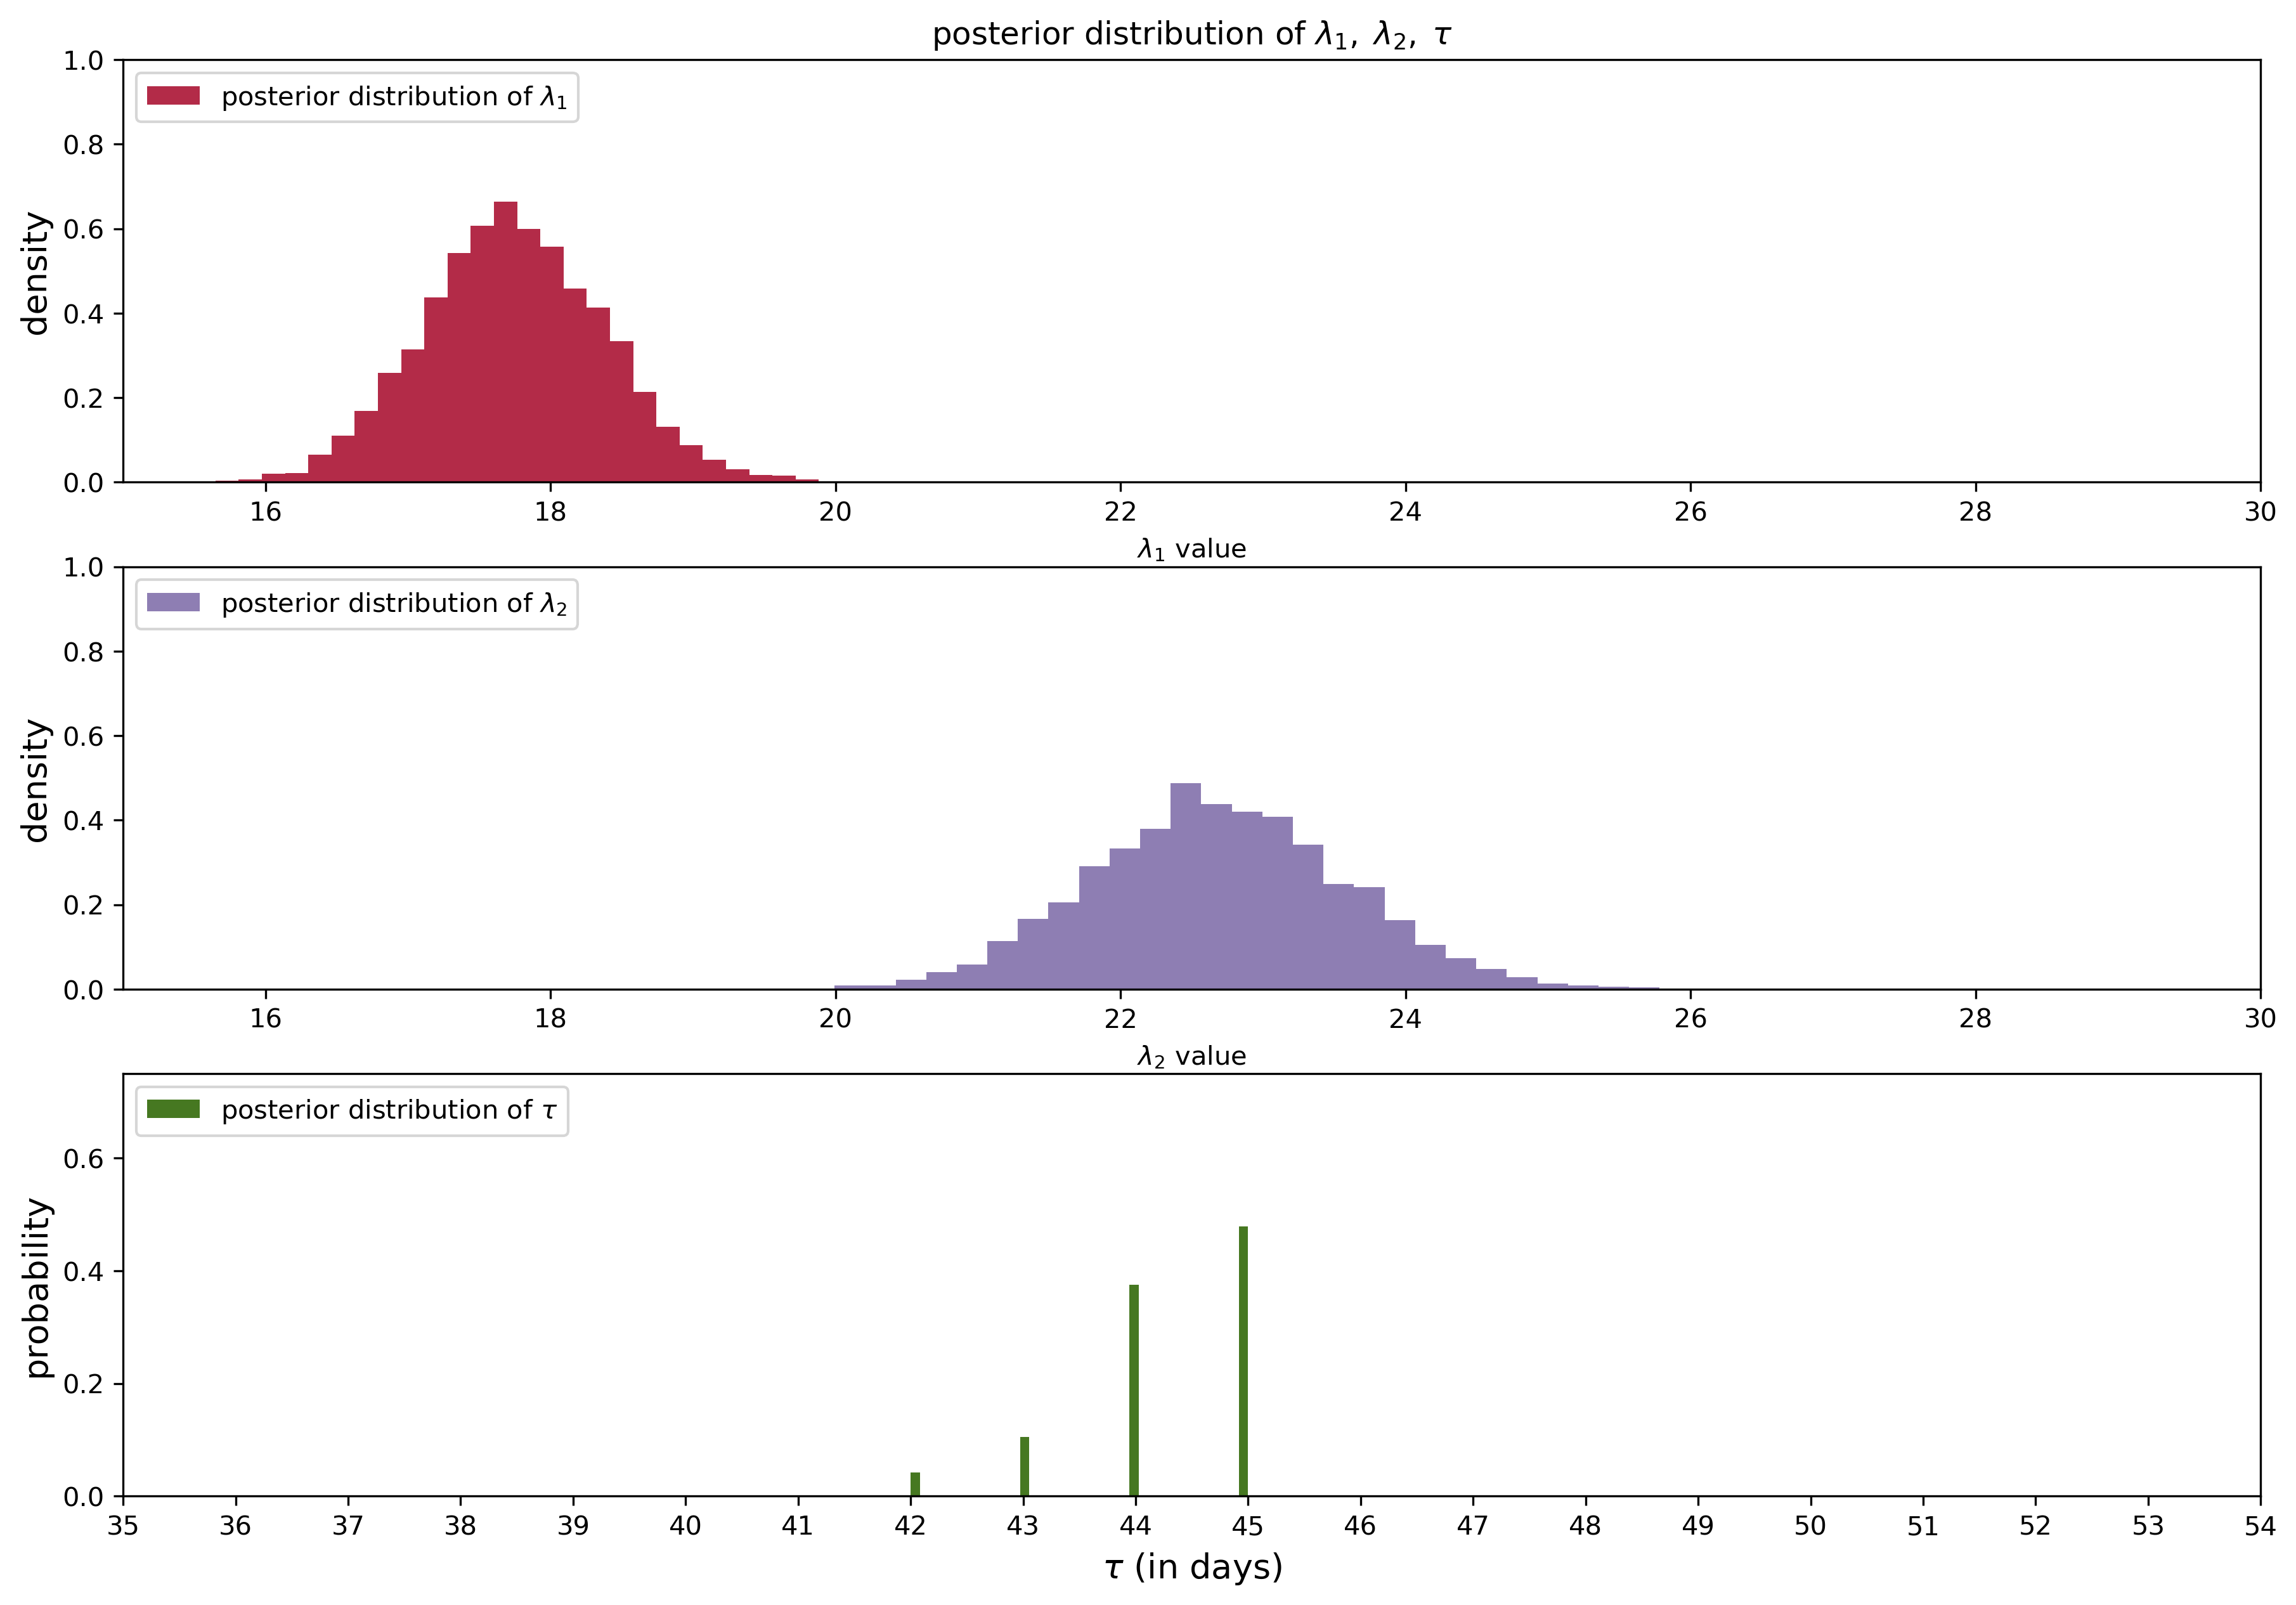

In [11]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

figsize(14.5, 10)

#표본의 히스토그램
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label="posterior distribution of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"posterior distribution of $\lambda_1,\;\lambda_2,\;\tau$")
plt.xlim([15,30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("density", fontsize=13)

ax = plt.subplot(312)
ax.set_autoscaley_on(False)

plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label="posterior distribution of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15,30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("density", fontsize=13)

ax = plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)

plt.hist(tau_samples, bins=n_count_data, alpha=1,
        label=r"posterior distribution of $\tau$", color="#467821",
        weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)", fontsize=13)
plt.ylabel("probability", fontsize=13)

[17.74148    17.74148    17.74148    17.74148    17.74148    17.74148
 17.74148    17.74148    17.74148    17.74148    17.74148    17.74148
 17.74148    17.74148    17.74148    17.74148    17.74148    17.74148
 17.74148    17.74148    17.74148    17.74148    17.74148    17.74148
 17.74148    17.74148    17.74148    17.74148    17.74148    17.74148
 17.74148    17.74148    17.74148    17.74148    17.74148    17.74148
 17.74148    17.74148    17.74148    17.741613   17.74172659 17.74336518
 17.9233636  18.40404558 20.26485994 22.69032486 22.69032486 22.69032486
 22.69032486 22.69032486 22.69032486 22.69032486 22.69032486 22.69032486
 22.69032486 22.69032486 22.69032486 22.69032486 22.69032486 22.69032486
 22.69032486 22.69032486 22.69032486 22.69032486 22.69032486 22.69032486
 22.69032486 22.69032486 22.69032486 22.69032486 22.69032486 22.69032486
 22.69032486 22.69032486]


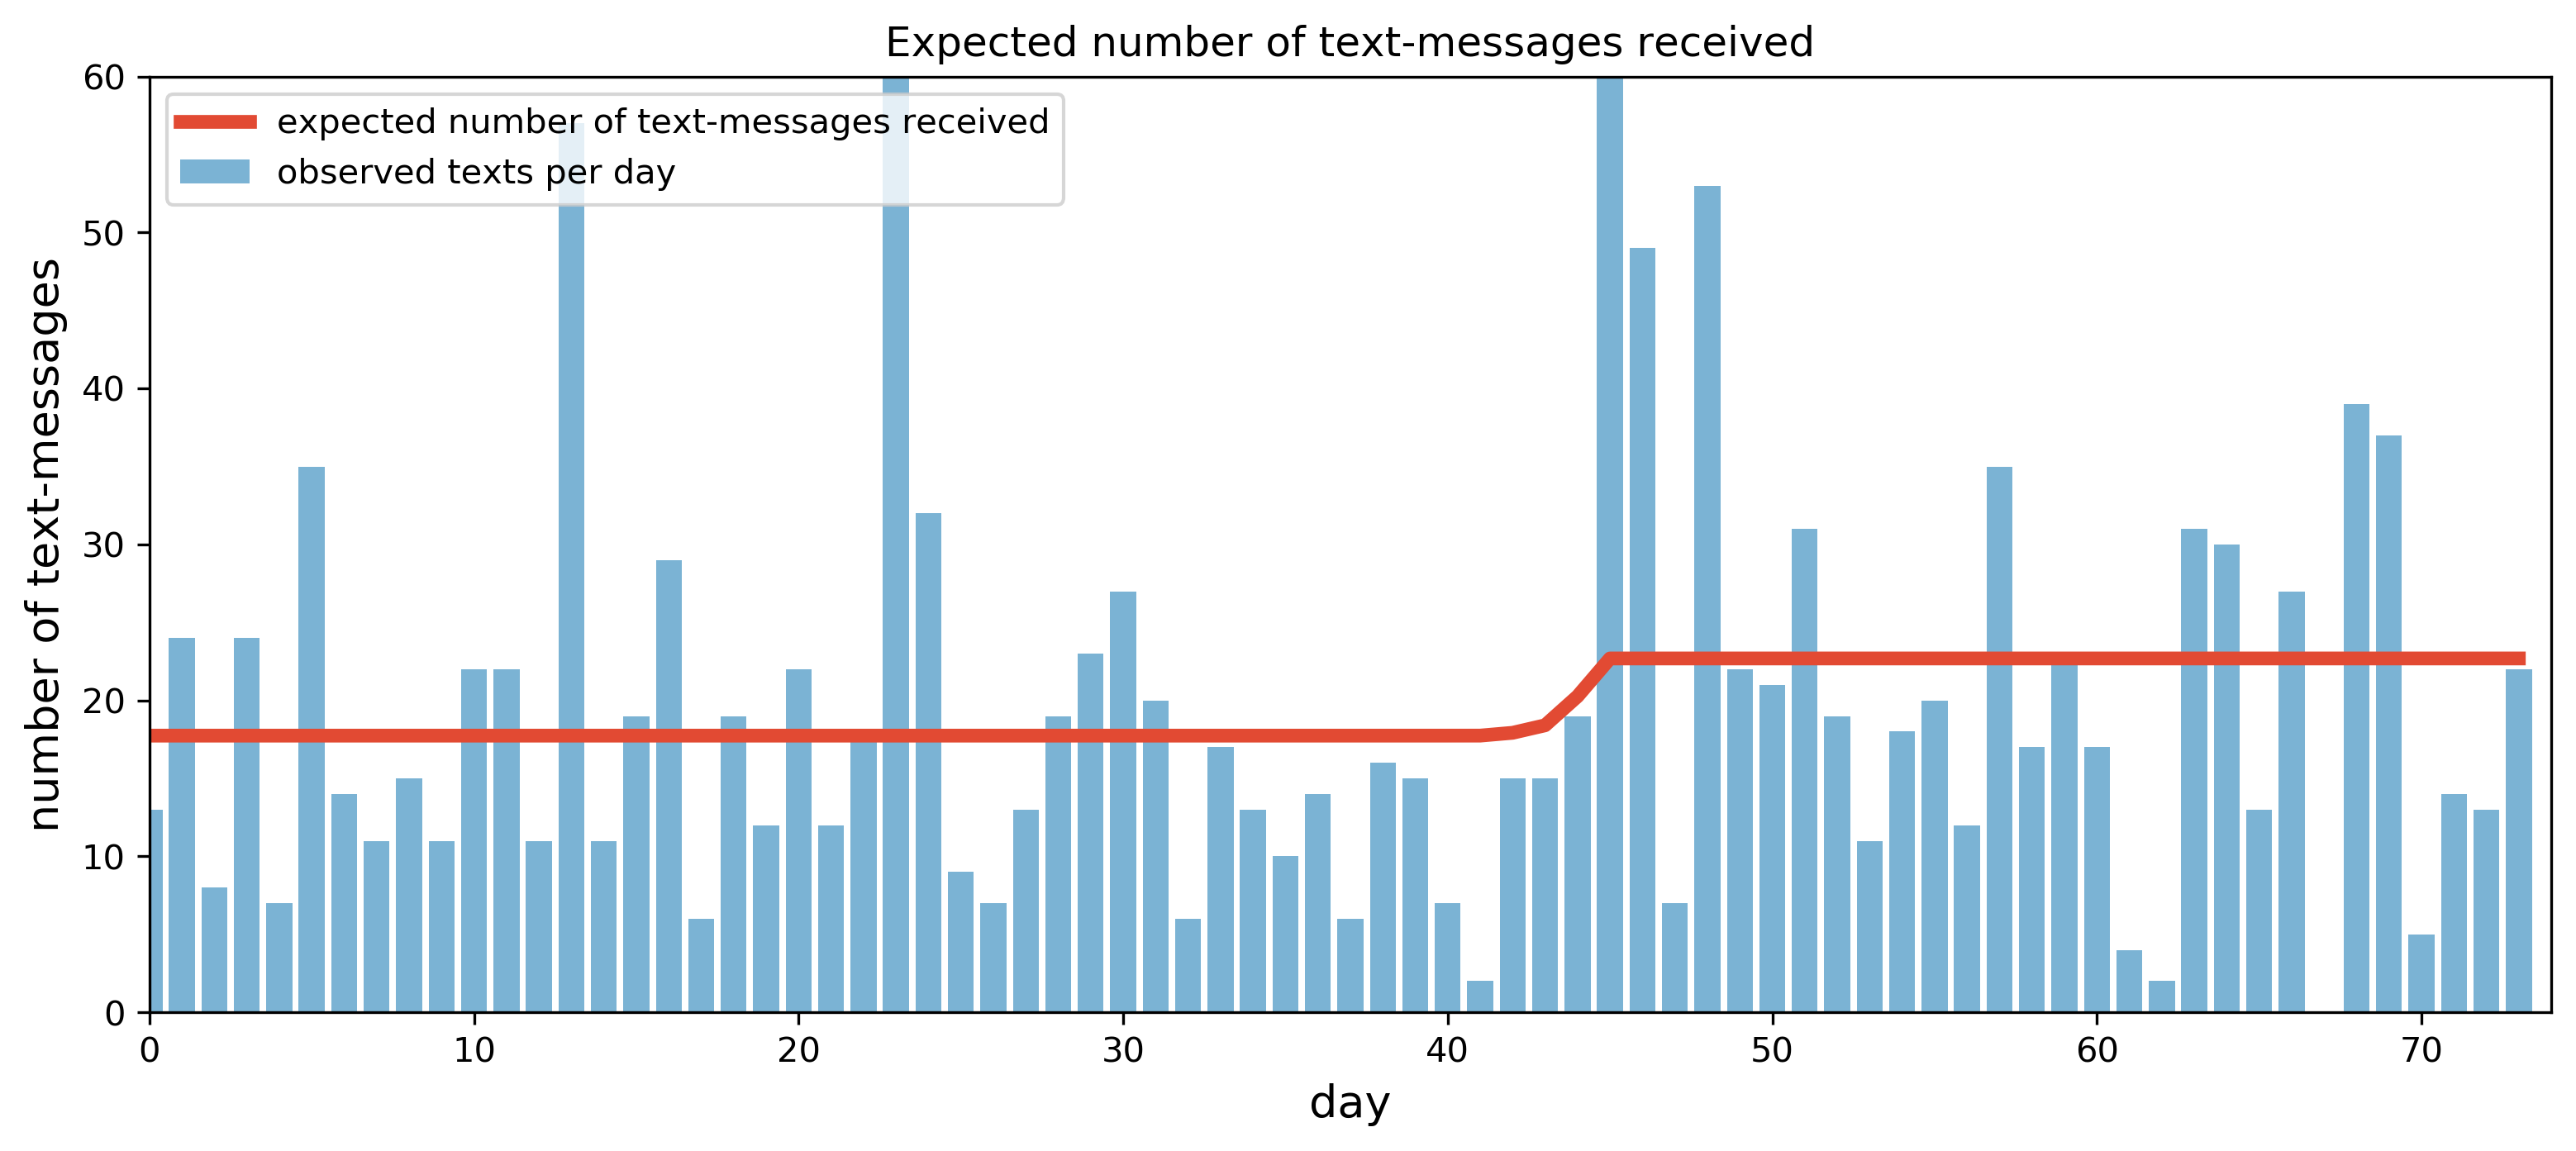

In [12]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples은
# 해당 사후확률분포에서 얻은 표본 N개가 포함된다.
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data) # 데이터 포인트 수
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N
    
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
        label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("day", fontsize=13)
plt.ylabel("number of text-messages", fontsize=13)
plt.title("Expected number of text-messages received")
plt.ylim(0,60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
       label="observed texts per day")
plt.legend(loc="upper left")
print(expected_texts_per_day)


## 두 $\lambda$가 정말 다른지 통계적으로 알 수 있나? 

In [13]:
print(lambda_1_samples < lambda_2_samples)

[ True  True  True ...  True  True  True]


In [14]:
print((lambda_1_samples < lambda_2_samples).mean())

1.0


In [15]:
for d in [1,2,5,10]:
    v = (abs(lambda_1_samples-lambda_2_samples)>=d).mean()
    print("What is the probability the difference is larger than %d? %.2f" % (d,v))

What is the probability the difference is larger than 1? 1.00
What is the probability the difference is larger than 2? 1.00
What is the probability the difference is larger than 5? 0.48
What is the probability the difference is larger than 10? 0.00


## 변환점 두개로 확장

In [16]:
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)

tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data-1)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)

@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2, lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):
    out = np.zeros(n_count_data)
    out[:tau_1] = lambda_1
    out[tau_1:tau_2] = lambda_2
    out[tau_2:] = lambda_3
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, lambda_3, tau_1, tau_2])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 8.8 sec

Text(0, 0.5, 'probability')

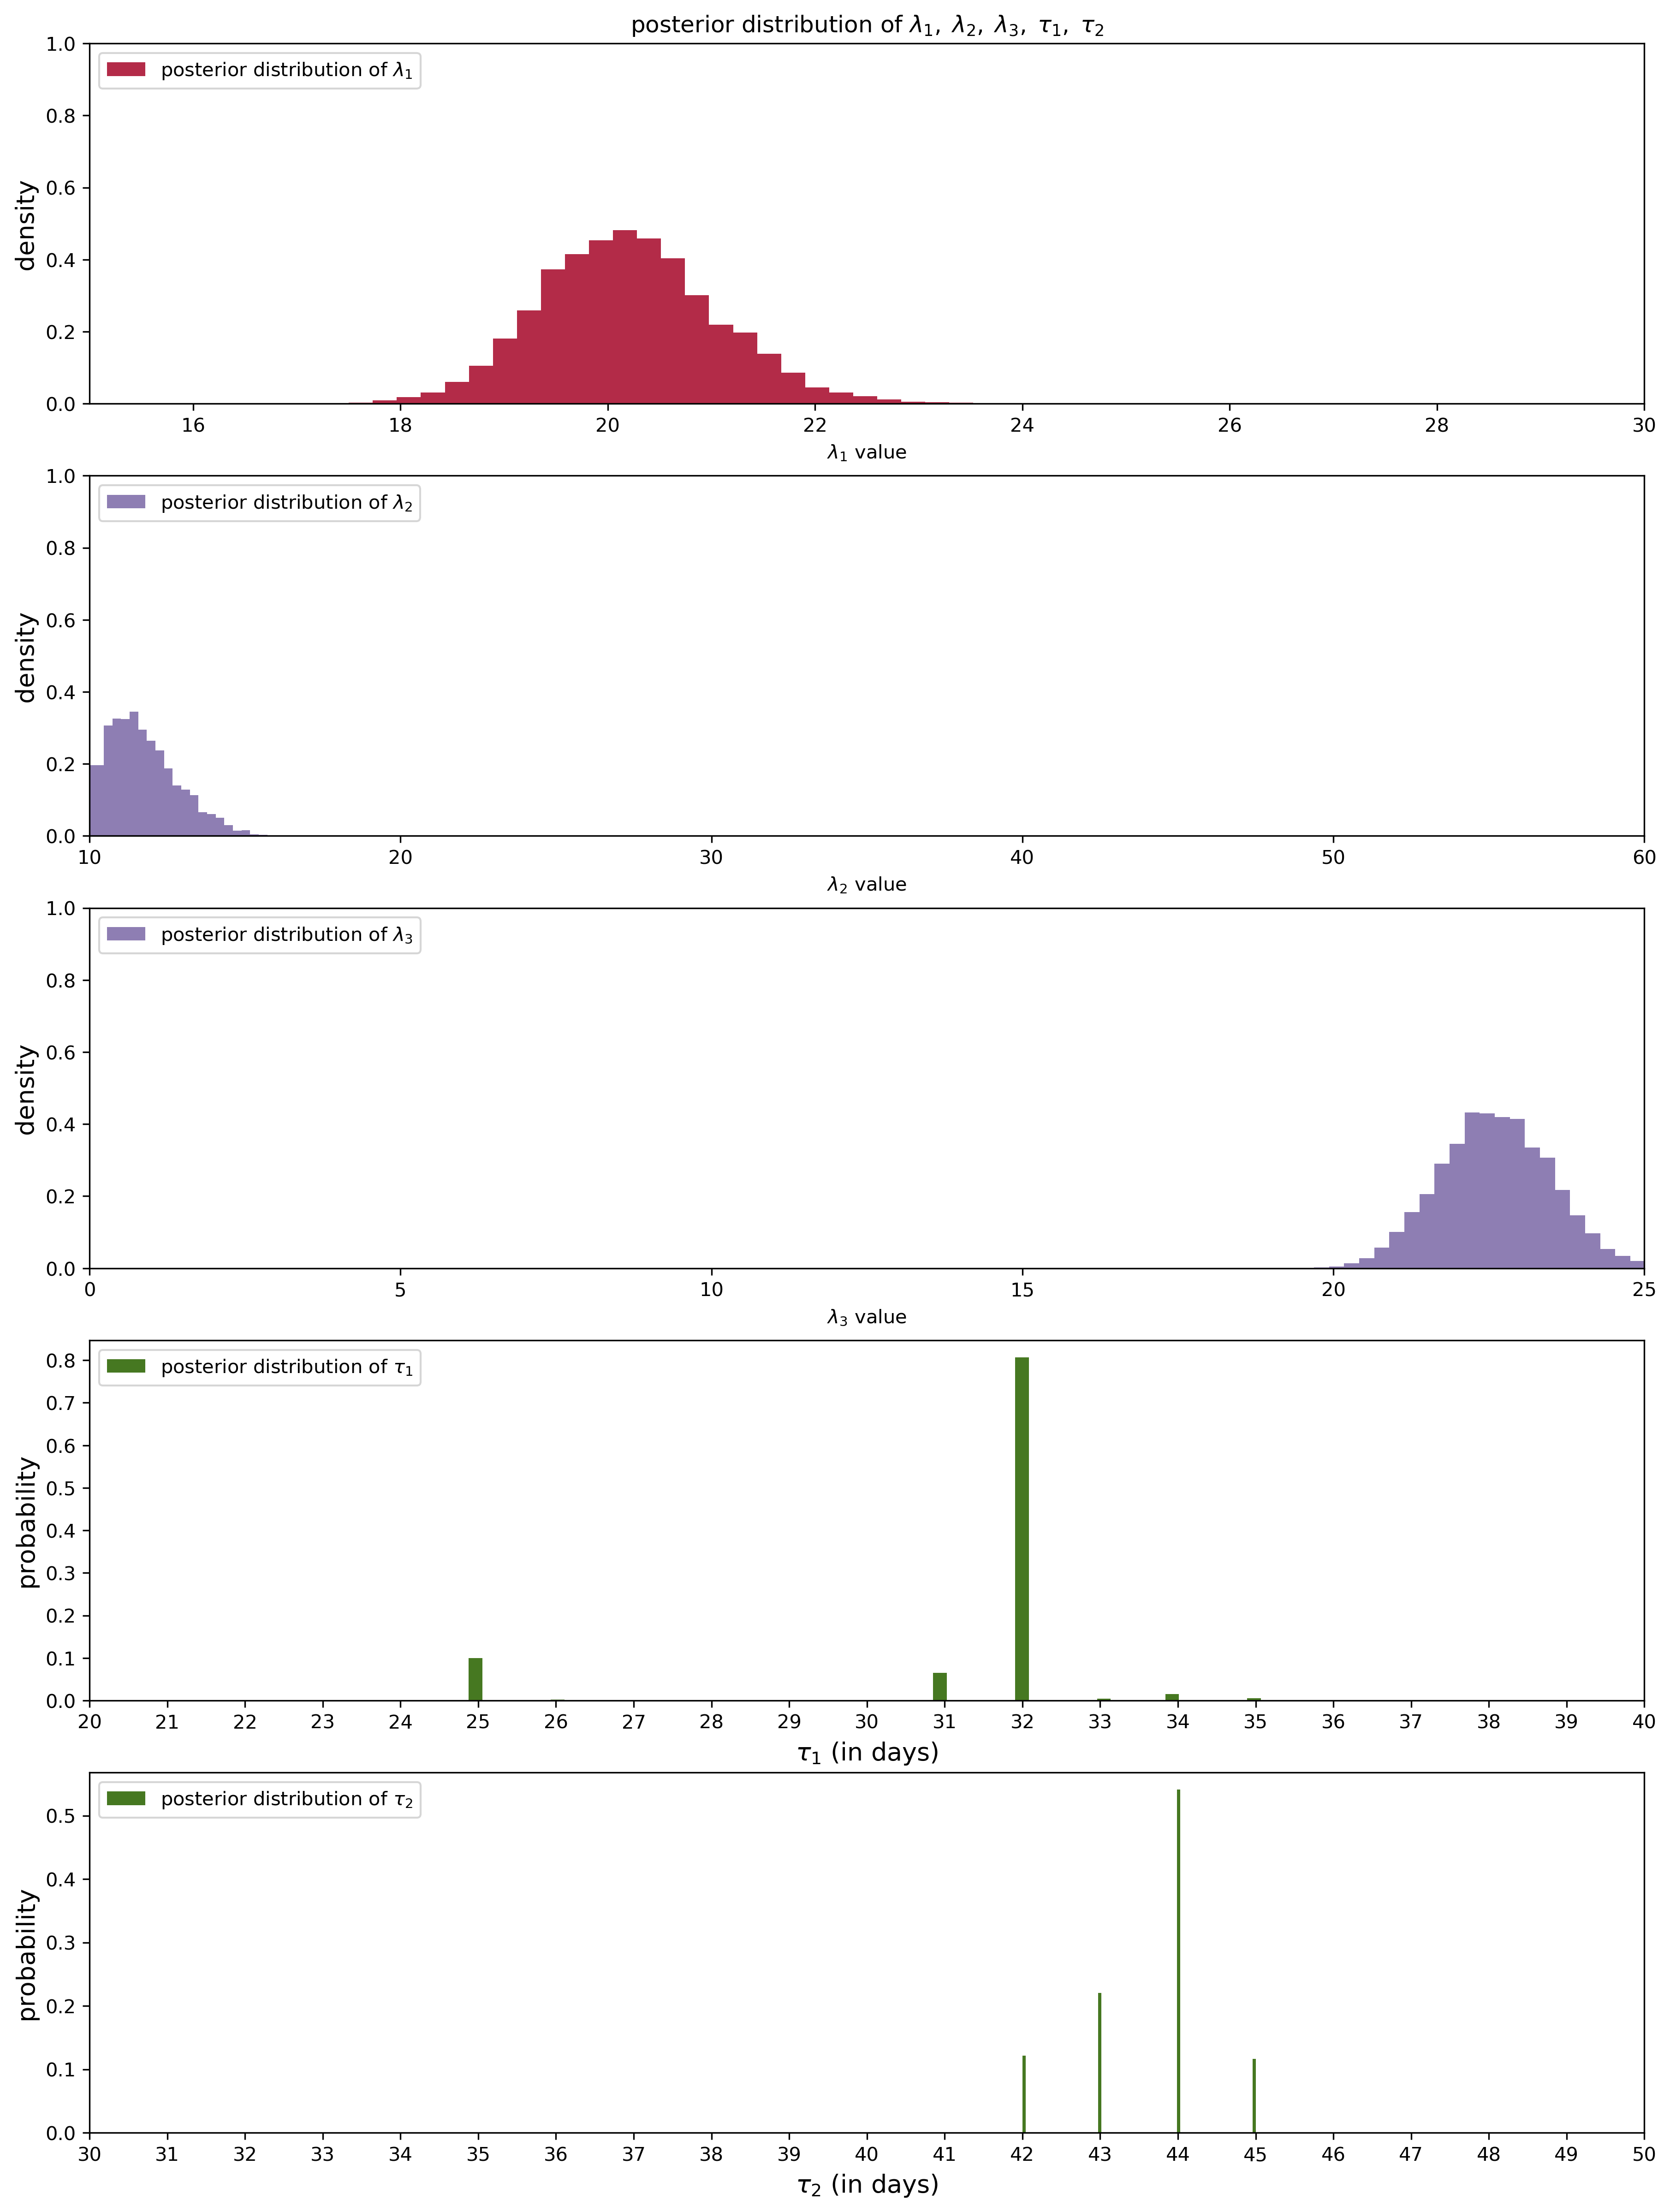

In [22]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
lambda_3_samples = mcmc.trace('lambda_3')[:]

tau_1_samples = mcmc.trace('tau_1')[:]
tau_2_samples = mcmc.trace('tau_2')[:]

figsize(14.5, 20)

#표본의 히스토그램
ax = plt.subplot(511)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label="posterior distribution of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"posterior distribution of $\lambda_1,\;\lambda_2,\;\lambda_3,\;\tau_1,\;\tau_2$")
plt.xlim([15,30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("density", fontsize=13)

ax = plt.subplot(512)
ax.set_autoscaley_on(False)

plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label="posterior distribution of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([10,60])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("density", fontsize=13)

ax = plt.subplot(513)
ax.set_autoscaley_on(False)

plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label="posterior distribution of $\lambda_3$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([0,25])
plt.xlabel("$\lambda_3$ value")
plt.ylabel("density", fontsize=13)

ax = plt.subplot(514)
w = 1.0 / tau_1_samples.shape[0] * np.ones_like(tau_1_samples)

plt.hist(tau_1_samples, bins=n_count_data, alpha=1,
        label=r"posterior distribution of $\tau_1$", color="#467821",
        weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.xlim([20, 40])
plt.xlabel(r"$\tau_1$ (in days)", fontsize=13)
plt.ylabel("probability", fontsize=13)

ax = plt.subplot(515)
w = 1.0 / tau_2_samples.shape[0] * np.ones_like(tau_2_samples)

plt.hist(tau_2_samples, bins=n_count_data, alpha=1,
        label=r"posterior distribution of $\tau_2$", color="#467821",
        weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.xlim([30, 50])
plt.xlabel(r"$\tau_2$ (in days)", fontsize=13)
plt.ylabel("probability", fontsize=13)

## 연습문제

In [18]:
#1
print(lambda_1_samples.mean())
print(lambda_2_samples.mean())

20.20470546977114
11.510409792517729


In [19]:
#2
print(((lambda_2_samples - lambda_1_samples) / lambda_1_samples).mean())

-0.4297090870144418


In [20]:
#3
ix = tau_samples < 45
print(lambda_1_samples[ix].mean())

20.206824917528817
